In [1]:
import tensorflow as tf
import utils
from matplotlib import pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

# --- Veri Yükleme ---
AUGMENTED_DATA_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification_Augmented"
train_df = utils.load_data("train", AUGMENTED_DATA_PATH)
valid_df = utils.load_data("valid", AUGMENTED_DATA_PATH)
test_df = utils.load_data("test", AUGMENTED_DATA_PATH)

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# --- 2. EfficientNet için Ön İşleme Fonksiyonu ---
def preprocess_image_for_efficientnet(image_path, img_size=(224,224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) # float'a çevir
    img = tf.keras.applications.efficientnet.preprocess_input(img) # efficientnet preprcess işlemi
    return img

def create_dataset_efficientnet(df, batch_size=32):
    images = df['filename'].values
    labels = df[['moderate', 'severe', 'no_accident']].values.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.map(lambda x, y: (preprocess_image_for_efficientnet(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset_efficientnet(train_df)
valid_dataset = create_dataset_efficientnet(valid_df)
test_dataset = create_dataset_efficientnet(test_df)

print(" Veri yükleme ve EfficientNet'e özel işleme tamamlandı.")

 Veri yükleme ve EfficientNet'e özel işleme tamamlandı.


In [4]:
# --- 4. Model Oluşturma, Derleme ---
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False#eğitilmiş model zaten üstüne eğitime ihtiyaç yok.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),#modelin ne kadar yanlış yaptığını söyleyen fonk.
    metrics=[CategoricalAccuracy(name="accuracy")]
)


In [5]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_files/best_EfficientNet_model.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=True #ssadece ağırlıklar
    )
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
530/530 [==============================] - 79s 134ms/step - loss: 0.5277 - accuracy: 0.7928 - val_loss: 0.4284 - val_accuracy: 0.8252 - lr: 1.0000e-04
Epoch 2/30
530/530 [==============================] - 67s 127ms/step - loss: 0.2619 - accuracy: 0.9131 - val_loss: 0.3514 - val_accuracy: 0.8564 - lr: 1.0000e-04
Epoch 3/30
530/530 [==============================] - 75s 141ms/step - loss: 0.1651 - accuracy: 0.9525 - val_loss: 0.3121 - val_accuracy: 0.8664 - lr: 1.0000e-04
Epoch 4/30
530/530 [==============================] - 68s 128ms/step - loss: 0.1183 - accuracy: 0.9672 - val_loss: 0.2938 - val_accuracy: 0.8783 - lr: 1.0000e-04
Epoch 5/30
530/530 [==============================] - 68s 127ms/step - loss: 0.0823 - accuracy: 0.9816 - val_loss: 0.2847 - val_accuracy: 0.8795 - lr: 1.0000e-04
Epoch 6/30
530/530 [==============================] - 67s 127ms/step - loss: 0.0634 - accuracy: 0.9857 - val_loss: 0.3003 - val_accuracy: 0.8752 - lr: 1.0000e-04
Epoch 7/30
530/530 [========

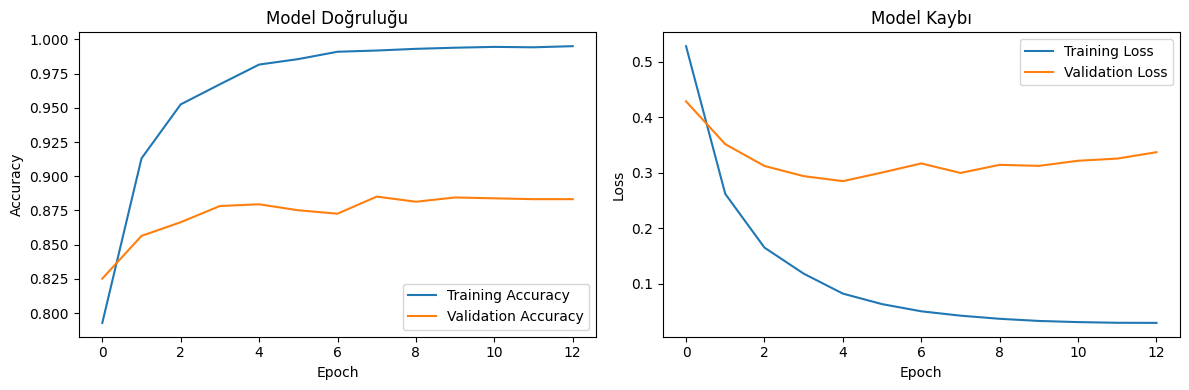

In [11]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9307
F1 Score: 0.9324
ROC-AUC Score: 0.9830


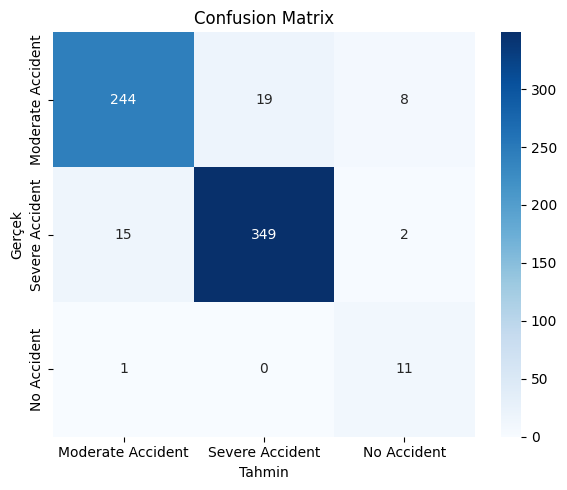


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.94      0.90      0.92       271
  Severe Accident       0.95      0.95      0.95       366
      No Accident       0.52      0.92      0.67        12

         accuracy                           0.93       649
        macro avg       0.80      0.92      0.85       649
     weighted avg       0.94      0.93      0.93       649



In [9]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, test_dataset, class_names)